In [147]:
include("/Users/tgordon/qual/celerite2d.jl/src/celerite.jl")
include("transit/transit.jl")
using Plots
using Unitful
using Statistics

# sets up transit centered at t0 with depth rp and impact parameter b
function setup_transit(t0, rp, b)
    
    Msun = 1.989e30
    Rsun = 6.95e8
    
    P = 50
    Psec = P*24*60*60
    a = (((Psec^2)*Unitful.G.val*Msun*1.04/(4*pi^2))^(1/3))/(1.73*Rsun)
    inc = acos(b/a)*(180/pi) 
    
    xp::Array{Number, 1} = zeros(10)
    xp[1] = P #P  (units of day)
    xp[2] = inc #inc = inclination angle
    xp[3] = rp # R_p/R_* = radius of planet in units of radius of star
    xp[4] = t0 #t0 = mid-point of transit
    xp[5] = 0.1 #u1 = linear limb-darkening coefficient
    xp[6] = 0.0 #u2 = quadratic limb-darkening coefficient
    xp[7] = 1.0 #f0 = uneclipsed flux
    xp[8] = a #a/R_* = semi-major axis divided by R_*
    xp[9] = 0.0 #e = eccentricity
    xp[10] = 90.0 #omega = longitude of pericentre
    return xp
end

# returns a transit light curve with transit parameters transitparams=[t0, rp, b] and variability GP parameters varparams=[log_S0, Q, W0]
function lightcurve(t, varparams, transitparams)
    
    t1 = celerite.SHOTerm(varparams[1], varparams[2], varparams[3])
    gp = celerite.Celerite(t1)
    celerite.compute!(gp, t, varparams[4])
    u = randn(length(t))
    flux = celerite.simulate_gp(gp, u)
    xp = setup_transit(transitparams[1], transitparams[2], transitparams[3])
    fp = transit(t, xp)
    return flux .+ fp
end

function lightcurve2d(t, scales, varparams, transitparams, unmix=true)
    
    Q = broadcast(*, scales, scales')
    n = length(scales)
    t1 = celerite.SHOTerm(varparams[1], varparams[2], varparams[3])
    gp = celerite.Celerite(t1, Q)
    celerite.compute!(gp, t, varparams[4])
    u = randn(length(t)*n)
    y = celerite.simulate_gp(gp, u)
    xp = setup_transit(transitparams[1], transitparams[2], transitparams[3])
    fp = transit(t, xp)
    if unmix
        flux = zeros(n, length(t))
        for i in 1:n
            flux[i,:] = y[i:n:end] .+ fp .- 1
        end
    else
        flux = zeros(length(y))
        for i in 1:n
            flux[i:n:end] .= y[i:n:end] .+ fp
        end
    end
    return flux
end

lightcurve2d (generic function with 2 methods)

In [148]:
# produce 2d data 
t = collect(0:0.001:2)
varparams = [-16.2478, -1.81818, 1.37842, 0.00065]
d0 = 0.025
transitparams = [1, d0, 0]
scales = [1, 1.5, 2, 3]
y2d = lightcurve2d(t, scales, varparams, transitparams, false)

plot(size=(1000, 300))
plot!(t, y2d[1:4:end], markershape=:circle, legend=false, markersize=1, linewidth=1, linealpha=0.0)
plot!(t, 0.01 .+ y2d[2:4:end], markershape=:circle, legend=false, markersize=1, linewidth=1, linealpha=0.0)
plot!(t, 0.02 .+ y2d[3:4:end], markershape=:circle, legend=false, markersize=1, linewidth=1, linealpha=0.0)
plot!(t, 0.03 .+ y2d[4:4:end], markershape=:circle, legend=false, markersize=1, linewidth=1, linealpha=0.0)

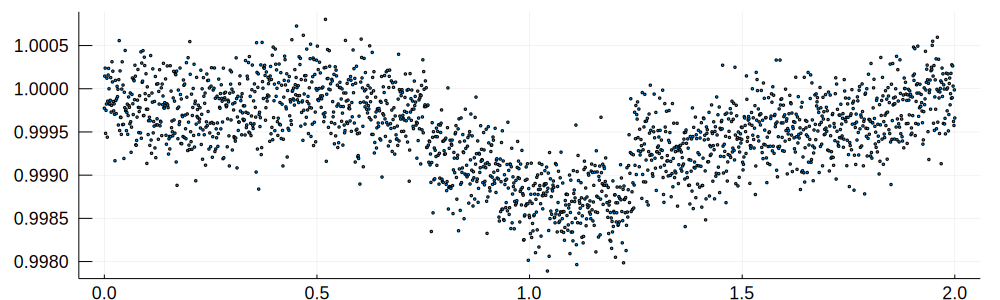

In [149]:
y1d = zeros(length(t))
for i in 1:length(t)
    y1d[i] = mean(y2d[4*(i-1)+1:4*i])
end
plot(size=(1000, 300))
plot!(t, y1d, markershape=:circle, legend=false, markersize=1, linewidth=1, linealpha=0.0)

In [150]:
using Optim

# log likelihood of variability + transit model 
function log_likelihood(t, varparams, transitparams, y)
    xp = setup_transit(transitparams[1], transitparams[2], transitparams[3])
    fp = transit(t, xp)
    y_notransit = y .- fp
    
    t1 = celerite.SHOTerm(varparams[1], varparams[2], varparams[3])
    gp = celerite.Celerite(t1)
    celerite.compute!(gp, t, varparams[4])
    return celerite.log_likelihood(gp, y_notransit)
end

# function to fit light curve y(t) holding depth d constant 
# for t0=5, b=0
function fitlc(t, y, d)
    
    function nll(p)
        varparams = vcat(p[1:3], exp(p[4]))
        transitparams = [1, d, 0.001]
        try
            return -log_likelihood(t, varparams, transitparams, y)
        catch
            println(p)
        end
    end
    
    # initial 
    initial_guess = [-16, -2, 1.5, log(0.0007)]
    upper = 20*ones(4)
    lower = -20*ones(4)
    
    upper[1] = 1
    lower[4] = -10

    res = optimize(nll, lower, upper, initial_guess, Fminbox(BFGS()); autodiff = :forward)
    return res.minimizer, -nll(res.minimizer)
end

function log_likelihood2d(t, scales, varparams, transitparams, y)
    xp = setup_transit(transitparams[1], transitparams[2], transitparams[3])
    fp = transit(t, xp)
    n = length(scales) + 1
    y_notransit::Array{Real} = zeros(length(y))
    for i in 1:n
        y_notransit[i:n:end] .= y[i:n:end] .- fp
    end
    
    scales = vcat([1], scales)
    Q = broadcast(*, scales, scales')
    t1 = celerite.SHOTerm(varparams[1], varparams[2], varparams[3])
    gp = celerite.Celerite(t1, Q)
    celerite.compute!(gp, t, varparams[4])
    return celerite.log_likelihood(gp, y_notransit)
end

function fitlc2d(t, y, n, d)
    
    function nll(p)
        # remember that scales is length n-1
        varparams = vcat(p[n:n+2], exp(p[n+3]))
        transitparams = [1, d, 0.001]
        try
            return -log_likelihood2d(t, p[1:n-1], varparams, transitparams, y)
        catch
            tries = 0
            while tries < 3
                try
                    p .= 0.999 .* p
                    return -log_likelihood2d(t, p[1:n-1], varparams, transitparams, y)
                catch
                    tries += 1
                end
                return 0
            end
        end
    end

    # initial 
    initial_guess = vcat(1.1*ones(n-1), [-16, -2, 1.5, log(0.0007)])
    upper = 10*ones(n + 3)
    lower = -20*ones(n + 3)
    
    lower[1:n-1] = ones(n-1)
    upper[1:n-1] = 10*ones(n-1)
    upper[n] = 1
    lower[n + 3] = -10

    res = optimize(nll, lower, upper, initial_guess, Fminbox(BFGS()); autodiff = :forward)
    return res.minimizer, -nll(res.minimizer)
end

fitlc2d (generic function with 1 method)

In [154]:
depths1d = vcat(collect(-0.01:0.001: -0.005), collect(-0.005:0.0002:0.005), collect(0.005:0.001:0.01)) .+ d0
like1d = zeros(length(depths1d))

currentmax = 0
maxparams1d = []
maxlike1d = 0
depthatmax1d = 0
for i in 1:length(depths1d)
    res, like1d[i] = fitlc(t, y1d, depths1d[i])
    if like1d[i] > currentmax
        maxparams1d = res
        maxlike1d = like1d[i]
        depthatmax1d = depths1d[i]
        currentmax = like1d[i]
    end
    print("\r", i, "/", length(depths1d), " depth = ", depths1d[i], " likelihood: ", like1d[i])
end

println("\r", "maximized parameters: ", maxparams1d)

maximized parameters: [-16.1133, -1.23672, 1.47699, -8.07005]


In [ ]:
depths2d = vcat(collect(-0.01:0.001: -0.003), collect(-0.003:0.0001:0.003), collect(0.003:0.001:0.01)) .+ d0
like2d = zeros(length(depths2d))

currentmax = 0
for i in 1:length(depths2d)
    res, like2d[i] = fitlc2d(t, y2d, 4, depths2d[i])
    if like2d[i] > currentmax
        maxparams2d = res
        maxlike2d = like2d[i]
        depthatmax2d = depths1d[i]
        currentmax = like2d[i]
    end
    print("\r", i, "/", length(depths2d), " depth = ", depths2d[i], " likelihood: ", like2d[i])
end
println("\r", "maximized parameters: ", maxparams2dm)

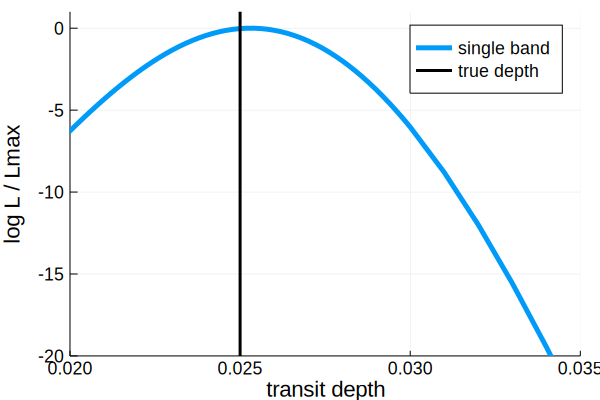

In [161]:
plot(xlims=(0.02, 0.035), ylims=(-20, 1), ylabel="log L / Lmax", xlabel="transit depth")
plot!(depths1d, like1d .- maximum(like1d), label="single band", linewidth=5)
plot!(depths2d, like2d .- maximum(like2d), label="four bands", linewidth=5)
vline!([0.025], linewidth=3, color=:black, label="true depth")

In [130]:
using ForwardDiff

varparams = vcat(maxparams1d[1:3], exp(maxparams1d[4]))
h(x::Real) = log_likelihood(t, varparams, [1, x, 0.001], y1d)
g(x::Real) = ForwardDiff.derivative(h, x)
x0 = depthatmax1d
second_der = ForwardDiff.derivative(g, x0)
log_A1 = log(sqrt(-second_der/(2*pi))) - log_likelihood(t,  varparams, [1, depthatmax1d, 0.001], y1d)

varparams = vcat(maxparams2d[4:6], exp(maxparams2d[7]))
scales = maxparams2d[1:3]
h(x::Real) = log_likelihood2d(t, scales, varparams, [1, x, 0.001], y2d)
g(x::Real) = ForwardDiff.derivative(h, x)
x0 = depthatmax2d
second_der = ForwardDiff.derivative(g, x0)
log_A2 = log(sqrt(-second_der/(2*pi))) - log_likelihood2d(t,  scales, varparams, [1, depthatmax2d, 0.001], y2d)

UndefVarError: UndefVarError: maxparams1d not defined

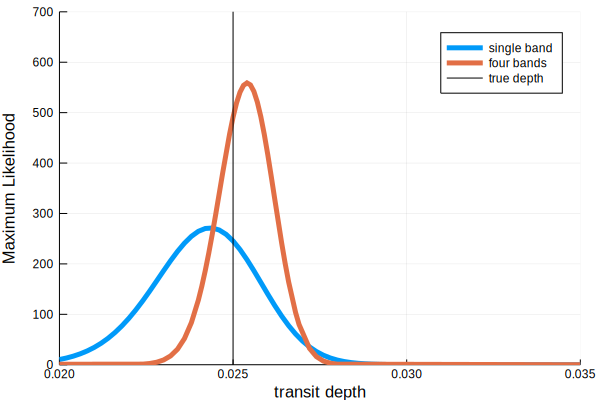

In [87]:
y = exp.(like2d .+ log_A2)
masky = y .> 1
ymasked = y[masky]
depthsmasked = depths2d[masky]

plot(xlims=(0.02, 0.035), ylims=(0, 700), ylabel="Maximum Likelihood", xlabel="transit depth", legend=:topright)
plot!(depths, exp.(like1d .+ log_A1), label="single band", linewidth=5)
plot!(vcat([0.01], depthsmasked, [0.035]), vcat([0], ymasked, [0]), label="four bands", linewidth=5)
vline!([0.025], linewidth=1, color=:black, label="true depth")

single band: 0.0029785319458710754
multiband: 0.0014708235990667203


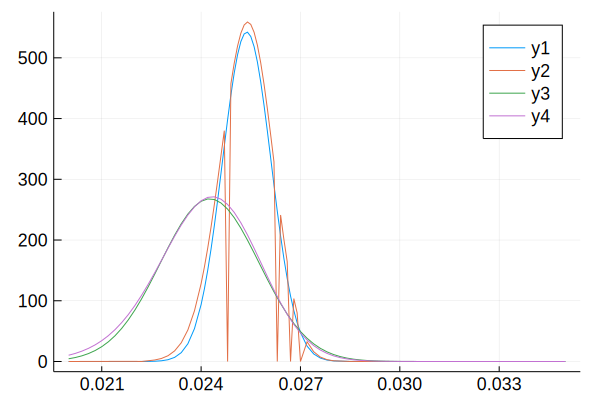

In [128]:
# fit curve with gaussian to find 95% confidence interval 
using LsqFit
gauss(x,p::Vector) = (sqrt(1/(2*pi))/p[1]).*exp.(-0.5*((x.-p[2]).^2)/(p[1]^2))

bestfit1d = curve_fit(gauss, depths, exp.(like1d .+ log_A1), [0.001, 0.02]).param
bestfit2d = curve_fit(gauss, depthsmasked, ymasked, [0.01, 0.015]).param

ci_single = 2*bestfit1d[1]
ci_multi = 2*bestfit2d[1]
println("single band: ",ci_single)
println("multiband: ",ci_multi)

plot(depths2d, gauss(depths2d, bestfit2d))
plot!(depths2d, exp.(like2d .+ log_A2))

plot!(depths, gauss(depths, bestfit1d))
plot!(depths, exp.(like1d .+ log_A1))

In [118]:
using Plots
Plots.scalefontsizes(1.5)
maxvarpar1d = [-15.2944, -2.60188, 1.78296, exp(-8.03468)]
maxtranspar1d = [1, depths[36], 0.001]
sigmadepth=ci_single
xpmin = setup_transit(maxtranspar1d[1], maxtranspar1d[2]-sigmadepth, maxtranspar1d[3])
xpmean = setup_transit(maxtranspar1d[1], maxtranspar1d[2], maxtranspar1d[3])
xpmax = setup_transit(maxtranspar1d[1], maxtranspar1d[2]+sigmadepth, maxtranspar1d[3])
fpmin = transit(t, xpmin)
fpmean = transit(t, xpmean)
fpmax = transit(t, xpmax)
y_notransit = y1d .- fpmean
t1 = celerite.SHOTerm(maxvarpar1d[1], maxvarpar1d[2], maxvarpar1d[3])
gp = celerite.Celerite(t1)
celerite.compute!(gp, t, maxvarpar1d[4])
ypred = celerite.predict!(gp, y_notransit, t, t)
plot(size=(800, 300), ylims=(0.997, 1.001), title="Single bandpass, 95% confidence interval", ylabel="normalized flux")
plot!(t, y1d, markershape=:circle, legend=false, markersize=1, linewidth=1, linealpha=0.0)
plot!(t, ypred', ribbon=(-fpmax , fpmin), legend=false, linewidth=2, color=:red)
plot!(t, ypred' .+ fpmean, legend=false, linewidth=3, color=:red)
plot1 = current()

plot(size=(800, 300), ylims=(0.998, 1.002), xlabel="time (days)", ylabel="normalized flux")
plot!(t, y1d .- ypred', markershape=:circle, legend=false, markersize=1, linewidth=1, linealpha=0.0)
plot!(t, ones(length(t)), ribbon=(-fpmax .+ 1, fpmin .- 1), legend=false, linewidth=0, color=:red)
plot!(t, fpmean, legend=false, linewidth=3, color=:red)
plot2 = current()

maxvarpar1d = [-16.2127, -1.853, 2.02506, exp(-8.04433)]
maxtranspar1d = [1, 0.0199, 0.001]
sigmadepth=ci_multi
xpmin = setup_transit(maxtranspar1d[1], maxtranspar1d[2]-sigmadepth, maxtranspar1d[3])
xpmean = setup_transit(maxtranspar1d[1], maxtranspar1d[2], maxtranspar1d[3])
xpmax = setup_transit(maxtranspar1d[1], maxtranspar1d[2]+sigmadepth, maxtranspar1d[3])
fpmin = transit(t, xpmin)
fpmean = transit(t, xpmean)
fpmax = transit(t, xpmax)
y_notransit = y1d .- fpmean   
t1 = celerite.SHOTerm(maxvarpar1d[1], maxvarpar1d[2], maxvarpar1d[3])
gp = celerite.Celerite(t1)
celerite.compute!(gp, t, maxvarpar1d[4])
ypred = celerite.predict!(gp, y_notransit, t, t)
plot(size=(800, 300), ylims=(0.997, 1.001), title="Four bandpass, 95% confidence interval")
plot!(t, y1d, markershape=:circle, legend=false, markersize=1, linewidth=1, linealpha=0.0)
plot!(t, ypred', ribbon=(-fpmax , fpmin), legend=false, linewidth=2, color=:red, alpha=0.8, linealpha=1)
plot!(t, ypred' .+ fpmean, legend=false, linewidth=3, color=:red)
plot3=current()

plot(size=(800, 300), ylims=(0.998, 1.002), xlabel="time (days)")
plot!(t, y1d .- ypred', markershape=:circle, legend=false, markersize=1, linewidth=1, linealpha=0.0)
plot!(t, ones(length(t)), ribbon=(-fpmax .+ 1, fpmin .- 1), legend=false, linewidth=0, color=:red, alpha=0.8, linealpha=1)
plot!(t, fpmean, legend=false, linewidth=3, color=:red)
plot4=current()

plot(plot1, plot3, plot2, plot4, layout=(2, 2), size=(1500, 600))

In [125]:
using DelimitedFiles
writedlm("plotsdata/depths3/depths3_1d.txt", hcat(depths, like1d))
writedlm("plotsdata/depths3/depths3_2d.txt", hcat(depths2d, like2d))
writedlm("plotsdata/depths3/depths3_lc.txt", y2d)
writedlm("plotsdata/depths3/depths3_times.txt", t)

In [141]:
writedlm("plotsdata/depths3/lc.txt", hcat(t, y2d[1:4:end], y2d[2:4:end], y2d[3:4:end], y2d[4:4:end]))